In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Event Connection

- To receive events, you need to create callback functions and then attach them to event manager, which is part of the >FigureCanvasBase. An example that prints the location of the mouse click and which button was pressed.

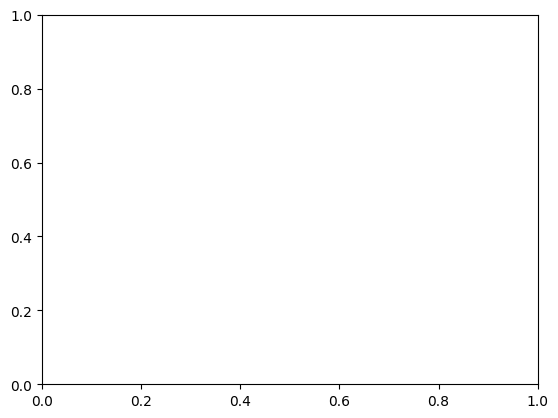

In [2]:
fig, ax = plt.subplots()
x = np.linspace(0, 10, 100)

def on_click(event):
    print(f"%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f " %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    
cid = fig.canvas.mpl_connect('button_press_event', on_click)

# fig.canvas.mpl_disconnect(cid)  # To disconnect the event

### Event Attributes

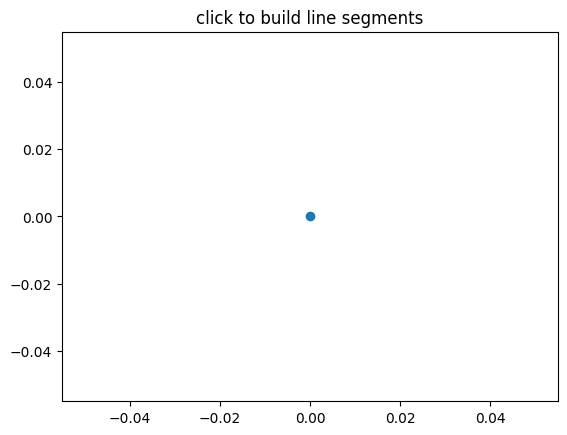

In [3]:
class LineBuilder:
    def __init__(self, line):
        self.line = line
        self.xs = list(line.get_xdata())
        self.ys = list(line.get_ydata())
        self.cid = line.figure.canvas.mpl_connect('button_press_event', self)
        
    def __call__(self, event):
        print('click', event)
        if event.inaxes != self.line.axes:
            return
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.line.set_data(self.xs, self.ys)
        self.line.figure.canvas.draw()
        
fig, ax = plt.subplots()
ax.set_title('click to build line segments')
line, = ax.plot([0], [0], 'o')   # empty line
linebuilder = LineBuilder(line)

plt.show()

In [ ]:
class DraggableRectangle:
    def __init__(self, rect):
        self.rect = rect
        self.press = None
        self.background = None
        self.cidpress = rect.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = rect.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)
        self.cidmotion = rect.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)
        
    def on_press(self, event):
        if event.inaxes != self.rect.axes:
            return
        contains, attrd = self.rect.contains(event)
        if not contains:
            return
        x0, y0 = self.rect.xy
        self.press = x0, y0, event.xdata, event.ydata

    def on_motion(self, event):
        if self.press is None:
            return
        if event.inaxes != self.rect.axes:
            return
        x0, y0, xpress, ypress = self.press
        dx = event.xdata - xpress
        dy = event.ydata - ypress
        self.rect.set_x(x0 + dx)
        self.rect.set_y(y0 + dy)
        self.rect.figure.canvas.draw()

    def on_release(self, event):
        self.press = None
        self.rect.figure.canvas.draw()

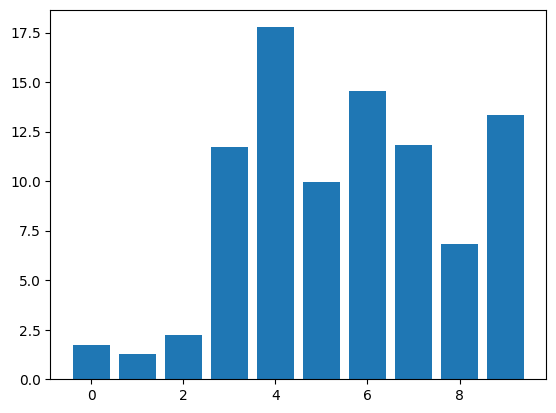

In [6]:
class DraggableRectangleTwo:
    def __init__(self, rect):
        self.rect = rect
        self.press = None
        
    def connect(self):
        """Connect all the events we need."""
        self.cidpress = self.rect.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.rect.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)
        self.cidmotion = self.rect.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)
        
    def on_press(self, event):
        if event.inaxes != self.rect.axes:
            return
        contains, attrd = self.rect.contains(event)  # Check if the click is within the rectangle 
        if not contains:
            return
        x0, y0 = self.rect.xy   # Get the current position of the rectangle
        self.press = self.rect.xy, event.xdata, event.ydata  # remember that self.rect.xy returns a tuple (x0, y0) with the lower-left corner coordinates
        print("press", self.press)
        print(f'\nx0={x0}, y0={y0}, event.xdata={event.xdata}, event.ydata={event.ydata}')
        print(f'Event contains: {self.rect.xy}')
        
    def on_motion(self, event):
        if self.press is None:
            return
        if event.axes != self.rect.axes:
            return
        x0, y0, xpress, ypress = self.press   # Unpack the stored data
        dx = event.xdata - xpress  # Calculate change in x
        dy = event.ydata - ypress  # Calculate change in y
        print(f'x0={x0}, xpress={xpress}, event.xdata={event.xdata}, 'f'dx={dx}, x0+dx={x0+dx}')
        self.rect.set_x(x0+dx)  # Update rectangle position
        self.rect.set_y(y0+dy)  # Update rectangle position
        
        self.rect.figure.canvas.draw()
        
    def on_release(self, event):
        """Clear the press data and redraw the rectangle."""
        self.press = None  # Clear the press data
        self.rect.figure.draw()  # trigger a redraw
        
    def disconnect(self):
        """Disconnect all the stored connection ids."""
        self.rect.figure.canvas.mpl_disconnect(self.cidpress)
        self.rect.figure.canvas.mpl_disconnect(self.cidrelease)
        self.rect.figure.canvas.mpl_disconnect(self.cidmotion)
        
fig, ax = plt.subplots()
rects = ax.bar(range(10), 20*np.random.rand(10))
drs = []  # list to store draggable rectangles
for rect in rects:
    dr = DraggableRectangleTwo(rect)
    dr.connect()
    drs.append(dr)
    
plt.show()

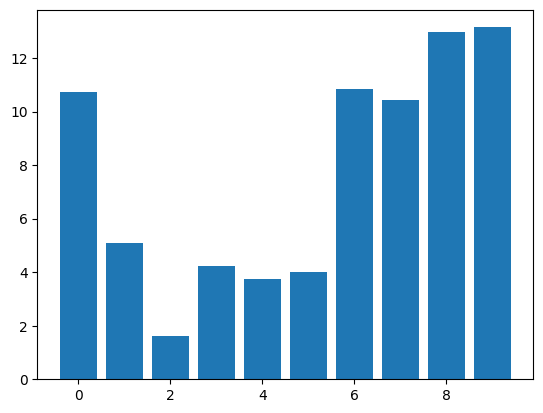

In [ ]:
# Draggable rectangle with blitting.
class DraggableRectangle:
    lock = None  # only one can be animated at a time

    def __init__(self, rect):
        self.rect = rect
        self.press = None
        self.background = None

    def connect(self):
        """Connect to all the events we need."""
        self.cidpress = self.rect.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.rect.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)
        self.cidmotion = self.rect.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)

    def on_press(self, event):
        """Check whether mouse is over us; if so, store some data."""
        if (event.inaxes != self.rect.axes
                or DraggableRectangle.lock is not None):
            return
        contains, attrd = self.rect.contains(event)
        if not contains:
            return
        print('event contains', self.rect.xy)
        self.press = self.rect.xy, (event.xdata, event.ydata)
        DraggableRectangle.lock = self

        # draw everything but the selected rectangle and store the pixel buffer
        canvas = self.rect.figure.canvas
        axes = self.rect.axes
        self.rect.set_animated(True)
        canvas.draw()
        self.background = canvas.copy_from_bbox(self.rect.axes.bbox)

        # now redraw just the rectangle
        axes.draw_artist(self.rect)

        # and blit just the redrawn area
        canvas.blit(axes.bbox)

    def on_motion(self, event):
        """Move the rectangle if the mouse is over us."""
        if (event.inaxes != self.rect.axes
                or DraggableRectangle.lock is not self):
            return
        (x0, y0), (xpress, ypress) = self.press
        dx = event.xdata - xpress
        dy = event.ydata - ypress
        self.rect.set_x(x0+dx)
        self.rect.set_y(y0+dy)

        canvas = self.rect.figure.canvas
        axes = self.rect.axes
        # restore the background region
        canvas.restore_region(self.background)

        # redraw just the current rectangle
        axes.draw_artist(self.rect)

        # blit just the redrawn area
        canvas.blit(axes.bbox)

    def on_release(self, event):
        """Clear button press information."""
        if DraggableRectangle.lock is not self:
            return

        self.press = None
        DraggableRectangle.lock = None

        # turn off the rect animation property and reset the background
        self.rect.set_animated(False)
        self.background = None

        # redraw the full figure
        self.rect.figure.canvas.draw()

    def disconnect(self):
        """Disconnect all callbacks."""
        self.rect.figure.canvas.mpl_disconnect(self.cidpress)
        self.rect.figure.canvas.mpl_disconnect(self.cidrelease)
        self.rect.figure.canvas.mpl_disconnect(self.cidmotion)

fig, ax = plt.subplots()
rects = ax.bar(range(10), 20*np.random.rand(10))
drs = []
for rect in rects:
    dr = DraggableRectangle(rect)
    dr.connect()
    drs.append(dr)

plt.show()

### Mouse Enter and Leave Events

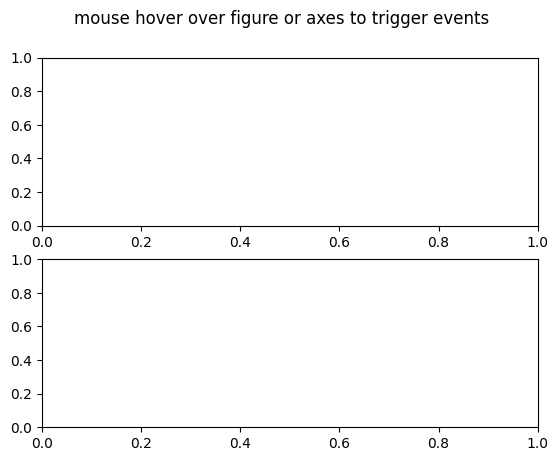

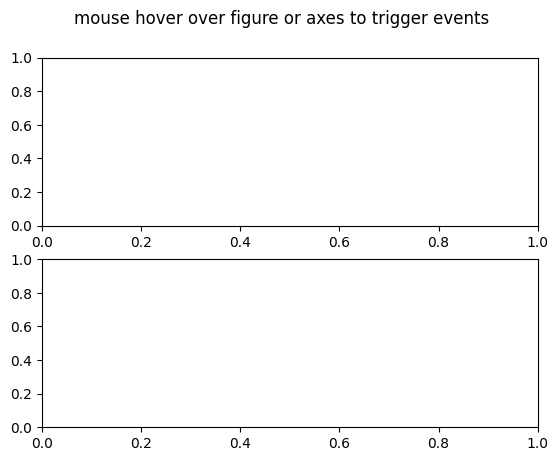

In [ ]:
"""
Illustrate the figure and axes enter and leave events by changing the
frame colors on enter and leave
"""
def enter_axes(event):
    print('enter_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('yellow')
    event.canvas.draw()

def leave_axes(event):
    print('leave_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('white')
    event.canvas.draw()

def enter_figure(event):
    print('enter_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('red')
    event.canvas.draw()

def leave_figure(event):
    print('leave_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('grey')
    event.canvas.draw()

fig1, axs = plt.subplots(2)
fig1.suptitle('mouse hover over figure or axes to trigger events')

fig1.canvas.mpl_connect('figure_enter_event', enter_figure)
fig1.canvas.mpl_connect('figure_leave_event', leave_figure)
fig1.canvas.mpl_connect('axes_enter_event', enter_axes)
fig1.canvas.mpl_connect('axes_leave_event', leave_axes)

fig2, axs = plt.subplots(2)
fig2.suptitle('mouse hover over figure or axes to trigger events')

fig2.canvas.mpl_connect('figure_enter_event', enter_figure)
fig2.canvas.mpl_connect('figure_leave_event', leave_figure)
fig2.canvas.mpl_connect('axes_enter_event', enter_axes)
fig2.canvas.mpl_connect('axes_leave_event', leave_axes)

plt.show()

### Object Picking

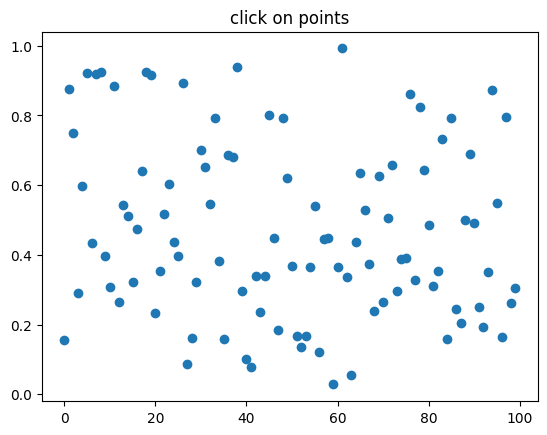

In [ ]:
fig, ax = plt.subplots()
ax.set_title('click on points')

line, = ax.plot(np.random.rand(100), 'o',
                picker=True, pickradius=5)  # 5 points tolerance

def onpick(event):
    thisline = event.artist
    xdata = thisline.get_xdata()
    ydata = thisline.get_ydata()
    ind = event.ind
    points = tuple(zip(xdata[ind], ydata[ind]))
    print('onpick points:', points)

fig.canvas.mpl_connect('pick_event', onpick)

plt.show()

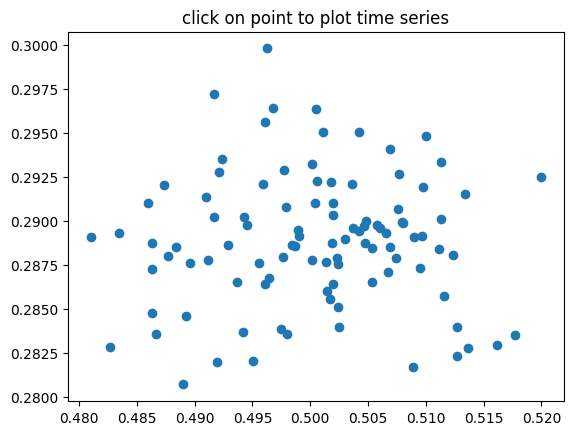

In [11]:
"""
Compute the mean and stddev of 100 data sets and plot mean vs. stddev.
When you click on one of the (mean, stddev) points, plot the raw dataset
that generated that point.
"""
X = np.random.rand(100, 1000)
xs = np.mean(X, axis=1)
ys = np.std(X, axis=1)

fig, ax = plt.subplots()
ax.set_title('click on point to plot time series')
line, = ax.plot(xs, ys, 'o', picker=True, pickradius=5)  # 5 points tolerance


def onpick(event):
    if event.artist != line:
        return
    n = len(event.ind)
    if not n:
        return
    fig, axs = plt.subplots(n, squeeze=False)
    for dataind, ax in zip(event.ind, axs.flat):
        ax.plot(X[dataind])
        ax.text(0.05, 0.9,
                f"$\\mu$={xs[dataind]:1.3f}\n$\\sigma$={ys[dataind]:1.3f}",
                transform=ax.transAxes, verticalalignment='top')
        ax.set_ylim(-0.5, 1.5)
    fig.show()
    return True


fig.canvas.mpl_connect('pick_event', onpick)
plt.show()